In [28]:
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("train.csv", parse_dates=['datetime'])
df_test = pd.read_csv("test.csv", parse_dates=['datetime'])

def EDA(df=df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['date'] = df['datetime'].dt.dayofweek
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    df['date'] = df['datetime'].dt.strftime('%Y%m%d')
    
    # new_col for continuous variables
    df['hour_dow'] = df['hour'].astype('str') + '_' +df['dayofweek'].astype('str')
    df['work_hour'] = df['workingday'].astype('str') + '_' +df['hour'].astype('str')
    
    # fill windspeed==0
    cond1 = df['windspeed'] == 0
    WinZeroDate = df[cond1]['date'].unique()
    i = 0
    while i < len(WinZeroDate):
        cond2 = df['date'] == WinZeroDate[i]
        mean = df[cond2]['windspeed'].mean()
        df.loc[cond1&cond2, 'windspeed'] = mean
        i += 1
    
    # fill humidity == 0
    cond1 = df['humidity'] == 0
    df.loc[cond1, 'humidity'] = 98.75
    
    return df

def to_cat(col_list=['season', 'weather'], df=df):
    for col in col_list: 
        df[col] = df[col].astype('category')

df = EDA(df)
df_test = EDA(df_test)

In [26]:
cat = ['season', 'workingday', 'weather', 'year', 'month', 'day', 'hour']
def to_cat(col_list=['season', 'weather'], df=df):
    for col in col_list: 
        df[col] = df[col].astype('category')

to_cat(col_list=cat, df=df)

필요 데이터
- y데이터를 왜 둘로 나눴는지(line plot)
- 왜 상호작용?(그냥 카테고리를 추가했을 때와의 다른점 -> 스캐터 플롯, regplot -> 유의미한지 비교하여 OLS
- 릿지, 라쏘 했을 때 모양

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


# independent values

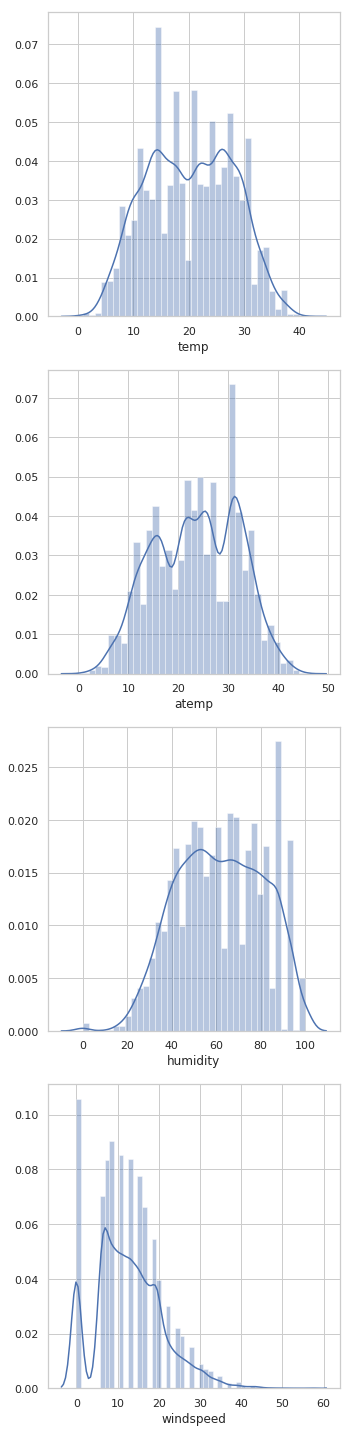

In [116]:
ls = ['temp', 'atemp', 'humidity', 'windspeed']

f, axes = plt.subplots(len(ls),1, figsize=(5,20))
idx = 0
for ax in axes:
    sns.distplot(df[ls[idx]], ax=ax)
    idx += 1
plt.tight_layout()
plt.show()

산점도 선형성 안보이는 이유

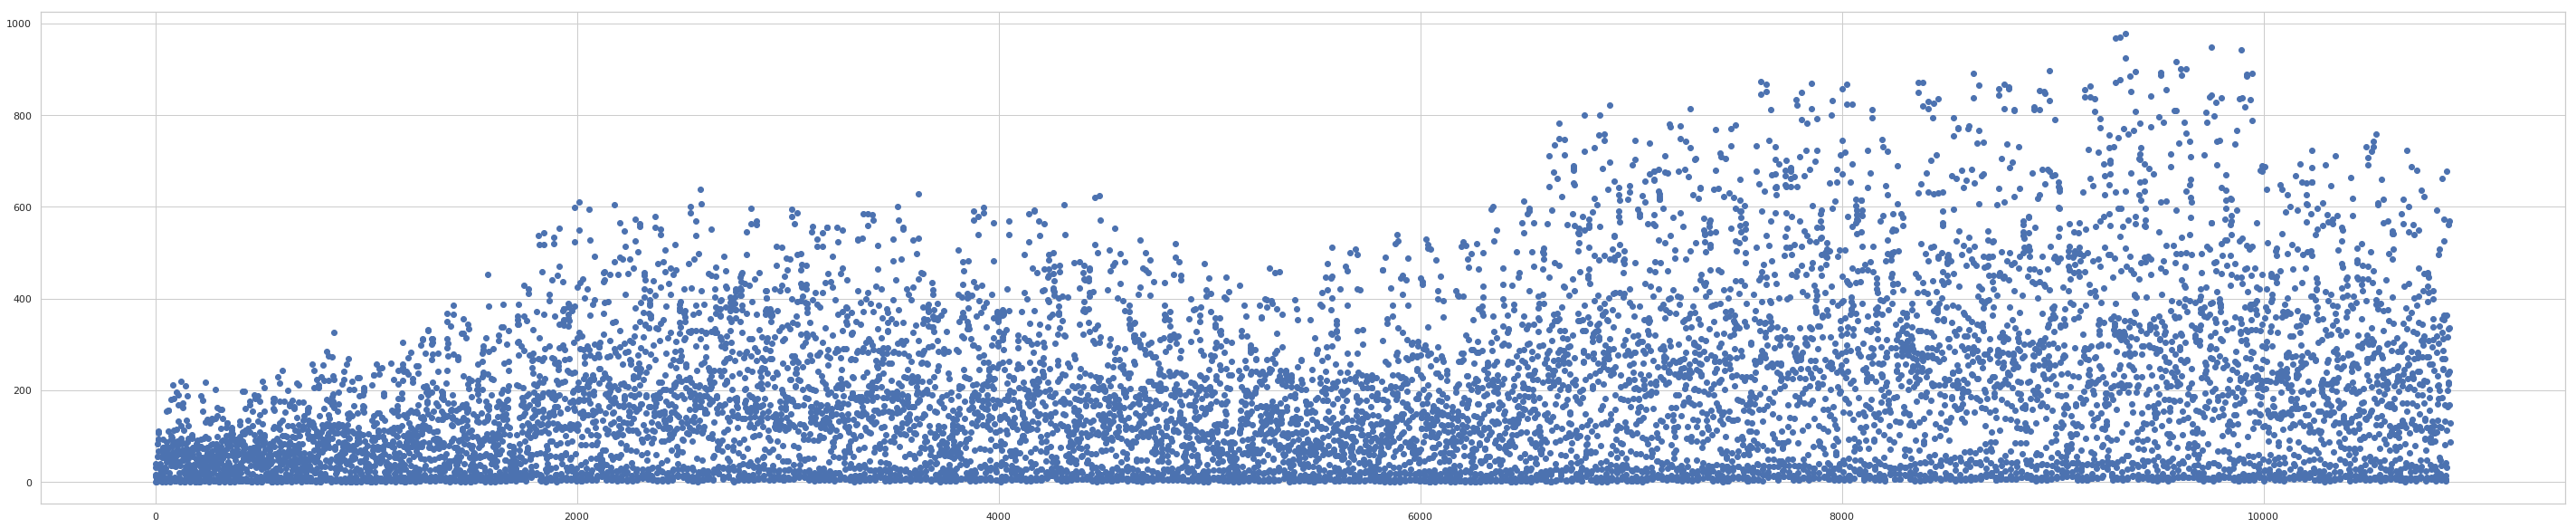

In [118]:
plt.figure(figsize=(50, 10))
plt.plot(df['count'], 'o')

In [161]:
len(df[df['count'] < 10])

1134

In [160]:
len(df[df['casual'] < 10])

4263

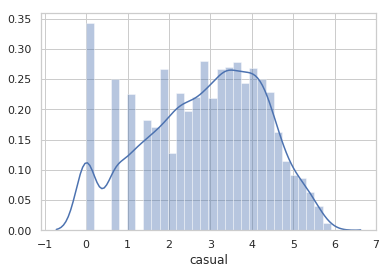

In [157]:
cond = df['casual'] > 0
sns.distplot(np.log(df[cond]['casual']))
plt.show()

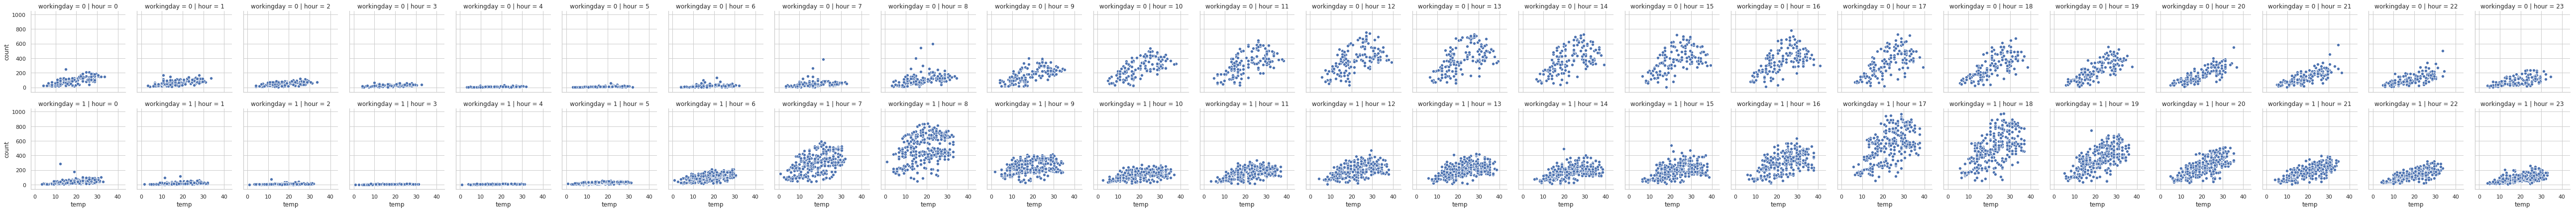

In [112]:
g = sns.FacetGrid(row='workingday', col='hour', data=df)
g.map(sns.scatterplot, 'temp', 'count')
plt.show()

# register vs casual
- F 검정 변수 중요도 차이
- 서로 다른 패턴 eg. hour:workingday

In [241]:
f = "count ~ humidity + temp + windspeed + C(workingday) + C(month) + C(holiday) + C(year) + C(hour) + C(day)-1"
fc = "casual ~ humidity + temp + windspeed + C(workingday) + C(month) + C(holiday) + C(year) + C(hour) + C(day)-1"
fr = "registered ~ humidity + temp + windspeed + C(workingday) + C(month) + C(holiday) + C(year) + C(hour) + C(day)-1"
m1 = sm.OLS.from_formula(f, df)
m2 = sm.OLS.from_formula(fr, df)
m3 = sm.OLS.from_formula(fc, df)

In [242]:
sm.stats.anova_lm(m1.fit(), typ=2).sort_values('F', ascending=False)

sum_sq       df            F         PR(>F)
C(year)        1.930123e+07      1.0  1876.777153   0.000000e+00
C(hour)        1.248465e+08     23.0   527.808238   0.000000e+00
humidity       5.004615e+06      1.0   486.629433  1.594533e-105
temp           2.829600e+06      1.0   275.139359   4.861888e-61
C(month)       8.168725e+06     11.0    72.208666  2.502390e-157
windspeed      7.018064e+05      1.0    68.240942   1.615466e-16
C(workingday)  2.225166e+05      2.0    10.818326   2.024646e-05
C(day)         3.489213e+05     18.0     1.884876   1.295940e-02
C(holiday)     1.504174e+04      1.0     1.462601   2.265432e-01
Residual       1.113475e+08  10827.0          NaN            NaN

In [243]:
sm.stats.anova_lm(m2.fit(), typ=2).sort_values('F', ascending=False)

sum_sq       df            F         PR(>F)
C(year)        1.460020e+07      1.0  2023.196676   0.000000e+00
C(hour)        1.022851e+08     23.0   616.260072   0.000000e+00
humidity       2.357274e+06      1.0   326.655102   5.844505e-72
C(workingday)  3.179112e+06      2.0   220.269954   1.709774e-94
temp           1.013123e+06      1.0   140.391813   3.453675e-32
C(month)       6.076930e+06     11.0    76.554539  7.127959e-167
windspeed      2.963578e+05      1.0    41.067259   1.531920e-10
C(day)         1.747017e+05     18.0     1.344943   1.485898e-01
C(holiday)     9.616220e+03      1.0     1.332551   2.483774e-01
Residual       7.813196e+07  10827.0          NaN            NaN

In [244]:
sm.stats.anova_lm(m3.fit(), typ=2).sort_values('F', ascending=False)

sum_sq       df            F         PR(>F)
C(workingday)  2.951067e+06      2.0  1445.734579   0.000000e+00
humidity       4.924644e+05      1.0   482.518790  1.144894e-104
temp           4.564368e+05      1.0   447.218845   2.656055e-97
C(year)        3.275230e+05      1.0   320.908480   9.596121e-71
C(hour)        3.105549e+06     23.0   132.296993   0.000000e+00
windspeed      8.605500e+04      1.0    84.317076   4.981452e-20
C(holiday)     4.871163e+04      1.0    47.727870   5.171732e-12
C(month)       4.026714e+05     11.0    35.867208   2.516920e-76
C(day)         6.057821e+04     18.0     3.297489   2.716824e-06
Residual       1.105016e+07  10827.0          NaN            NaN

# 상호작용항

- f = 'count ~ temp*C(weather)-1'
    - 절편, 기울기가 변함

$$
Y = w_0x + \\ 
w_1 d_{w1} + w_2 d_{w2} 
+ w_3 d_{w3} + w_4 d_{w4} + \\
{w_5}(xd_{w1}) + {w_6}(xd_{w2}) 
+ {w_7}(xd_{w3}) + {w_8}(xd_{w4})
$$


- f = 'count ~ temp/C(weather)-1'
    - 절편=0 고정, 기울기만 변함

$$
Y = w_1x_t +\\
w_2(d_2x_t) + w_3(d_3x_t) + w_4(d_4x_t)
$$

In [44]:
df['new'] = df['work_hour'].astype('str') + '_' + df['month'].astype('str')  # this is the calculated field

In [47]:
f = "np.log(count+1) ~ C(new)*scale(temp)"
mod = sm.OLS.from_formula(f, data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(count + 1)   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     85.94
Date:                Sun, 16 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:23:47   Log-Likelihood:                -6128.1
No. Observations:               10886   AIC:                         1.456e+04
Df Residuals:                    9734   BIC:                         2.296e+04
Df Model:                        1151                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.8598      0.285     13.536      0.000       3.301       4.419
C(new)[T.0_0_10]                  0.8741      0.330      2.652      0.008       0.228       1.520
C(new)[T.0_0_11]                  0.4408      0.545      0.810      0.418      -0.627       1.508
C(new)[T.0_0_12]                  1.0752      0.544      1.975      0.048       0.008       2.142
C(new)[T.0_0_2]                   0.3555      0.449      0.791      0.429      -0.526       1.237
C(new)[T.0_0_3]                   0.4363      0.354      1.234      0.217      -0.257       1.129
C(new)[T.0_0_4]                   0.2415      0.331      0.730      0.465      -0.407       0.890
C(new)[T.0_0_5]                   0.7434      0.322      2.307      0.021       0.112       1.375
C(new)[T.0_0_6]                   1.0198      0.432      2.360      0.018       0.173       1.867
C(new)[T.0_0_7]                   0.8709      0.563      1.548      0.122      -0.232       1.974
C(new)[T.0_0_8]                   0.4856      0.826      0.588      0.557      -1.133       2.105
C(new)[T.0_0_9]                   0.9345      0.358      2.609      0.009       0.232       1.637
C(new)[T.0_10_1]                  0.4720      0.486      0.972      0.331      -0.480       1.424
C(new)[T.0_10_10]                 1.8586      0.313      5.930      0.000       1.244       2.473
C(new)[T.0_10_11]                 1.9326      0.454      4.258      0.000       1.043       2.822
C(new)[T.0_10_12]                 1.9745      0.549      3.599      0.000       0.899       3.050
C(new)[T.0_10_2]                  1.1847      0.555      2.134      0.033       0.097       2.273
C(new)[T.0_10_3]                  1.2933      0.390      3.315      0.001       0.529       2.058
C(new)[T.0_10_4]                  1.5365      0.319      4.810      0.000       0.910       2.163
C(new)[T.0_10_5]                  1.6437      0.388      4.241      0.000       0.884       2.403
C(new)[T.0_10_6]                  2.2769      0.493      4.618      0.000       1.310       3.243
C(new)[T.0_10_7]                  1.8068      0.656      2.755      0.006       0.521       3.093
C(new)[T.0_10_8]                  1.9191      0.795      2.414      0.016       0.361       3.477
C(new)[T.0_10_9]                  1.8160      0.401      4.523      0.000       1.029       2.603
C(new)[T.0_11_1]                  1.2930      0.474      2.726      0.006       0.363       2.223
C(new)[T.0_11_10]                 1.9957      0.314      6.352      0.000       1.380       2.612
C(new)[T.0_11_11]                 2.1896      0.390      5.618      0.000       1.426       2.954
C(new)[T.0_11_12]                 2.3545      0.561      4.200      0.000       1.256       3.453
C(new)[T.0_11_2]                  1.3264     

In [90]:
idx[0]

array([   2,    3,    4,    5,    6,    9,   10,   12,   16,   58,   70,
         94,  106,  118,  124,  130,  132,  133,  134,  135,  136,  137,
        138,  139,  140,  141,  142,  143,  144,  148,  153,  154,  156,
        160,  165,  166,  168,  172,  174,  175,  177,  178,  180,  182,
        183,  184,  185,  186,  187,  189,  190,  191,  192,  193,  194,
        195,  196,  197,  198,  199,  200,  201,  202,  203,  204,  205,
        206,  207,  211,  212,  213,  214,  215,  219,  226,  230,  241,
        242,  246,  248,  249,  250,  253,  255,  256,  259,  260,  261,
        262,  263,  267,  268,  269,  271,  273,  274,  276,  279,  280,
        281,  286,  288,  289,  290,  291,  292,  293,  294,  295,  296,
        297,  298,  299,  300,  309,  311,  321,  323,  335,  346,  347,
        359,  369,  370,  371,  418,  429,  430,  442,  454,  465,  466,
        468,  470,  471,  472,  473,  474,  475,  477,  478,  479,  489,
        516,  517,  519,  521,  524,  525,  526,  5

In [ ]:
df

In [111]:
s = 'C(new)[T.1_7_4]:scale(temp)'
a = ' '
a.replace(':scale(temp)', '')

' '

In [95]:
param = pd.DataFrame(res.params.index)
param = param.loc[idx[0]]
param

0
2                 C(new)[T.0_0_11]
3                 C(new)[T.0_0_12]
4                  C(new)[T.0_0_2]
5                  C(new)[T.0_0_3]
6                  C(new)[T.0_0_4]
9                  C(new)[T.0_0_7]
10                 C(new)[T.0_0_8]
12                C(new)[T.0_10_1]
16                C(new)[T.0_10_2]
58                C(new)[T.0_13_8]
70                C(new)[T.0_14_8]
94                C(new)[T.0_16_8]
106               C(new)[T.0_17_8]
118               C(new)[T.0_18_8]
124               C(new)[T.0_19_2]
130               C(new)[T.0_19_8]
132                C(new)[T.0_1_1]
133               C(new)[T.0_1_10]
134               C(new)[T.0_1_11]
135               C(new)[T.0_1_12]
136                C(new)[T.0_1_2]
137                C(new)[T.0_1_3]
138                C(new)[T.0_1_4]
139                C(new)[T.0_1_5]
140                C(new)[T.0_1_6]
141                C(new)[T.0_1_7]
142                C(new)[T.0_1_8]
143                C(new)[T.0_1_9]
144               C(new)[T.0_20_1]
148               C(new)[T.0_20_2]
...                            ...
1122   C(new)[T.1_7_4]:scale(temp)
1123   C(new)[T.1_7_5]:scale(temp)
1124   C(new)[T.1_7_6]:scale(temp)
1125   C(new)[T.1_7_7]:scale(temp)
1126   C(new)[T.1_7_8]:scale(temp)
1127   C(new)[T.1_7_9]:scale(temp)
1128   C(new)[T.1_8_1]:scale(temp)
1129  C(new)[T.1_8_10]:scale(temp)
1130  C(new)[T.1_8_11]:scale(temp)
1131  C(new)[T.1_8_12]:scale(temp)
1132   C(new)[T.1_8_2]:scale(temp)
1133   C(new)[T.1_8_3]:scale(temp)
1134   C(new)[T.1_8_4]:scale(temp)
1135   C(new)[T.1_8_5]:scale(temp)
1136   C(new)[T.1_8_6]:scale(temp)
1137   C(new)[T.1_8_7]:scale(temp)
1138   C(new)[T.1_8_8]:scale(temp)
1139   C(new)[T.1_8_9]:scale(temp)
1140   C(new)[T.1_9_1]:scale(temp)
1141  C(new)[T.1_9_10]:scale(temp)
1142  C(new)[T.1_9_11]:scale(temp)
1143  C(new)[T.1_9_12]:scale(temp)
1144   C(new)[T.1_9_2]:scale(temp)
1145   C(new)[T.1_9_3]:scale(temp)
1146   C(new)[T.1_9_4]:scale(temp)
1147   C(new)[T.1_9_5]:scale(temp)
1148   C(new)[T.1_9_6]:scale(temp)
1149   C(new)[T.1_9_7]:scale(temp)
1150   C(new)[T.1_9_8]:scale(temp)
1151   C(new)[T.1_9_9]:scale(temp)

[714 rows x 1 columns]

In [78]:
idx = np.where(res.pvalues > 0.03)

In [43]:
f = "np.log(count+1) ~ humidity/C(work_hour) + temp/C(work_hour) + windspeed/C(work_hour) + C(year) + C(month)"
mod = sm.OLS.from_formula(f, data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(count + 1)   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     701.6
Date:                Sun, 16 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:18:59   Log-Likelihood:                -6108.4
No. Observations:               10886   AIC:                         1.253e+04
Df Residuals:                   10729   BIC:                         1.368e+04
Df Model:                         156                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          3.9905      0.028    143.164      0.000       3.936       4.045
C(year)[T.2012]                    0.4495      0.008     53.782      0.000       0.433       0.466
C(month)[T.2]                      0.1488      0.020      7.290      0.000       0.109       0.189
C(month)[T.3]                      0.2565      0.022     11.815      0.000       0.214       0.299
C(month)[T.4]                      0.3702      0.023     15.990      0.000       0.325       0.416
C(month)[T.5]                      0.6275      0.026     23.908      0.000       0.576       0.679
C(month)[T.6]                      0.5065      0.030     16.983      0.000       0.448       0.565
C(month)[T.7]                      0.3718      0.034     11.096      0.000       0.306       0.437
C(month)[T.8]                      0.4399      0.032     13.555      0.000       0.376       0.504
C(month)[T.9]                      0.5797      0.029     19.996      0.000       0.523       0.636
C(month)[T.10]                     0.7282      0.025     29.150      0.000       0.679       0.777
C(month)[T.11]                     0.7340      0.021     34.304      0.000       0.692       0.776
C(month)[T.12]                     0.7023      0.021     33.077      0.000       0.661       0.744
humidity                          -0.0101      0.001     -6.963      0.000      -0.013      -0.007
humidity:C(work_hour)[T.0_1]       0.0009      0.002      0.448      0.654      -0.003       0.005
humidity:C(work_hour)[T.0_10]      0.0086      0.002      4.365      0.000       0.005       0.012
humidity:C(work_hour)[T.0_11]      0.0100      0.002      4.972      0.000       0.006       0.014
humidity:C(work_hour)[T.0_12]      0.0125      0.002      6.259      0.000       0.009       0.016
humidity:C(work_hour)[T.0_13]      0.0114      0.002      5.541      0.000       0.007       0.015
humidity:C(work_hour)[T.0_14]      0.0095      0.002      4.649      0.000       0.006       0.014
humidity:C(work_hour)[T.0_15]      0.0089      0.002      4.434      0.000       0.005       0.013
humidity:C(work_hour)[T.0_16]      0.0076      0.002      3.763      0.000       0.004       0.012
humidity:C(work_hour)[T.0_17]      0.0057      0.002      2.870      0.004       0.002       0.010
humidity:C(work_hour)[T.0_18]      0.0041      0.002      2.057      0.040       0.000       0.008
humidity:C(work_hour)[T.0_19]      0.0037      0.002      1.874      0.061      -0.000       0.008
humidity:C(work_hour)[T.0_2]      -0.0014      0.002     -0.680      0.496      -0.005       0.003
humidity:C(work_hour)[T.0_20]      0.0019      0.002      0.940      0.347      -0.002       0.006
humidity:C(work_hour)[T.0_21]      0.0008      0.002      0.387      0.698      -0.003       0.005
humidity:C(wor

In [31]:
# 답안작성
f = "np.log(count+1) ~ humidity/C(work_hour) + temp/C(work_hour) + windspeed/C(work_hour)-1"
mod = sm.OLS.from_formula(f, data=df)
res = mod.fit()
sub = pd.read_csv("sampleSubmission.csv")
c = np.exp(res.predict(df_test)) - 1

sub['count'] = c
sub.fillna(1, inplace=True)
sub.loc[sub['count'] < 0, 'count'] = 1
sub.to_csv("submission1.csv", index=False)

In [201]:
t = 'count ~ temp*C(hour)-1'
m = sm.OLS.from_formula(t, df)
rt = m.fit()
rt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     391.1
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        22:23:28   Log-Likelihood:                -66648.
No. Observations:               10886   AIC:                         1.334e+05
Df Residuals:                   10838   BIC:                         1.337e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(hour)[0]            11.4116     14.654      0.779      0.436     -17.313      40.137
C(hour)[1]            12.4279     14.384      0.864      0.388     -15.767      40.623
C(hour)[2]             8.8297     14.514      0.608      0.543     -19.621      37.280
C(hour)[3]             5.3284     14.976      0.356      0.722     -24.028      34.685
C(hour)[4]             2.3585     14.541      0.162      0.871     -26.144      30.861
C(hour)[5]             6.5037     13.907      0.468      0.640     -20.757      33.764
C(hour)[6]            25.8143     13.619      1.895      0.058      -0.881      52.510
C(hour)[7]            86.2301     13.315      6.476      0.000      60.130     112.330
C(hour)[8]           222.3497     13.361     16.641      0.000     196.159     248.540
C(hour)[9]           132.8453     13.727      9.678      0.000     105.938     159.752
C(hour)[10]           68.6753     14.170      4.846      0.000      40.899      96.452
C(hour)[11]           73.9530     14.795      4.998      0.000      44.952     102.954
C(hour)[12]           93.9949     15.125      6.215      0.000      64.348     123.642
C(hour)[13]           94.1057     15.661      6.009      0.000      63.408     124.803
C(hour)[14]           85.4179     15.895      5.374      0.000      54.261     116.575
C(hour)[15]           91.4256     16.120      5.671      0.000      59.827     123.024
C(hour)[16]           86.5552     16.172      5.352      0.000      54.855     118.255
C(hour)[17]          103.3168     15.830      6.526      0.000      72.286     134.347
C(hour)[18]           67.7463     15.618      4.338      0.000      37.131      98.361
C(hour)[19]           26.5342     15.419      1.721      0.085      -3.690      56.758
C(hour)[20]            2.0765     15.332      0.135      0.892     -27.976      32.129
C(hour)[21]            4.3284     15.217      0.284      0.776     -25.500      34.156
C(hour)[22]            5.0573     14.999      0.337      0.736     -24.343      34.458
C(hour)[23]            8.7590     14.891      0.588      0.556     -20.430      37.948
temp                   2.2998      0.721      3.190      0.001       0.887       3.713
temp:C(hour)[T.1]     -1.1501      1.019     -1.129      0.259      -3.147       0.847
temp:C(hour)[T.2]     -1.5375      1.029     -1.495      0.135      -3.554       0.479
temp:C(hour)[T.3]     -1.9511      1.047     -1.863      0.062      -4.004       0.102
temp:C(hour)[T.4]     -2.0753      1.041     -1.993      0.046      -4.117      -0.034
temp:C(hour)[T.5]     -1.5466      1.028     -1.505      0.132      -3.561       0.468
temp:C(hour)[T.6]      0.5858      1.019      0.575      0.565      -1.412       2.584
temp:C(hour)[T.7]      4.8336      0.998      4.845      0.000       2.878       6.789
temp:C(hour)[T.8]      5.3062      0.9

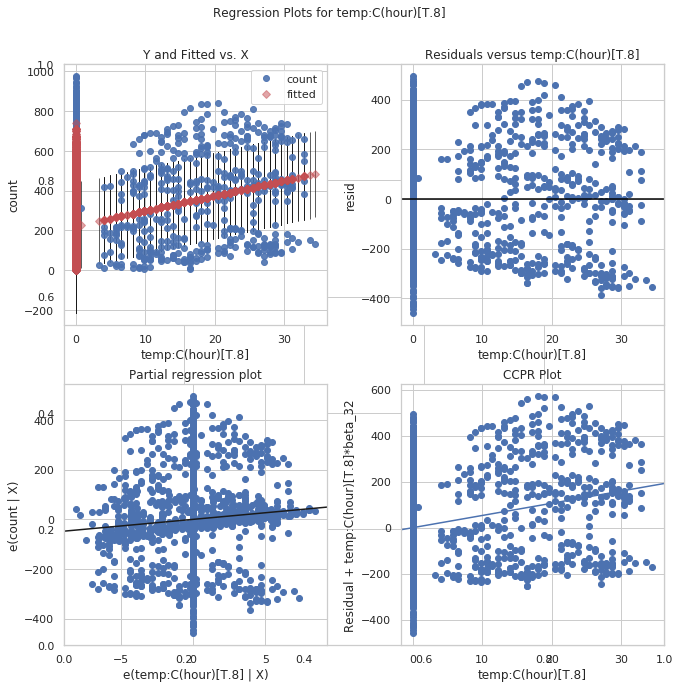

In [199]:
f, ax = plt.subplots(figsize=(10,10))
sm.graphics.plot_regress_exog(rt, 'temp:C(hour)[T.8]', fig=f)
plt.show()

In [49]:
t1 = 'count ~ temp/C(hour)-1'
m1 = sm.OLS.from_formula(t1, df)
rt1 = m1.fit()
rt1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     391.1
Date:                Sun, 16 Dec 2018   Prob (F-statistic):               0.00
Time:                        00:28:19   Log-Likelihood:                -66648.
No. Observations:               10886   AIC:                         1.334e+05
Df Residuals:                   10838   BIC:                         1.337e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.4116     14.654      0.779      0.436     -17.313      40.137
C(hour)[T.1]           1.0163     20.534      0.049      0.961     -39.234      41.267
C(hour)[T.2]          -2.5819     20.626     -0.125      0.900     -43.012      37.848
C(hour)[T.3]          -6.0831     20.953     -0.290      0.772     -47.155      34.989
C(hour)[T.4]          -9.0531     20.644     -0.439      0.661     -49.519      31.413
C(hour)[T.5]          -4.9079     20.203     -0.243      0.808     -44.509      34.693
C(hour)[T.6]          14.4027     20.006      0.720      0.472     -24.812      53.617
C(hour)[T.7]          74.8186     19.800      3.779      0.000      36.007     113.630
C(hour)[T.8]         210.9381     19.831     10.637      0.000     172.066     249.810
C(hour)[T.9]         121.4338     20.079      6.048      0.000      82.075     160.793
C(hour)[T.10]         57.2638     20.385      2.809      0.005      17.306      97.222
C(hour)[T.11]         62.5415     20.824      3.003      0.003      21.723     103.360
C(hour)[T.12]         82.5833     21.060      3.921      0.000      41.303     123.864
C(hour)[T.13]         82.6942     21.448      3.856      0.000      40.653     124.735
C(hour)[T.14]         74.0064     21.619      3.423      0.001      31.628     116.384
C(hour)[T.15]         80.0140     21.786      3.673      0.000      37.310     122.718
C(hour)[T.16]         75.1436     21.824      3.443      0.001      32.365     117.923
C(hour)[T.17]         91.9052     21.572      4.260      0.000      49.620     134.190
C(hour)[T.18]         56.3348     21.417      2.630      0.009      14.354      98.316
C(hour)[T.19]         15.1227     21.272      0.711      0.477     -26.574      56.819
C(hour)[T.20]         -9.3350     21.209     -0.440      0.660     -50.908      32.238
C(hour)[T.21]         -7.0832     21.126     -0.335      0.737     -48.494      34.327
C(hour)[T.22]         -6.3542     20.969     -0.303      0.762     -47.458      34.749
C(hour)[T.23]         -2.6525     20.892     -0.127      0.899     -43.605      38.300
temp                   2.2998      0.721      3.190      0.001       0.887       3.713
temp:C(hour)[T.1]     -1.1501      1.019     -1.129      0.259      -3.147       0.847
temp:C(hour)[T.2]     -1.5375      1.029     -1.495      0.135      -3.554       0.479
temp:C(hour)[T.3]     -1.9511      1.047     -1.863      0.062      -4.004       0.102
temp:C(hour)[T.4]     -2.0753      1.041     -1.993      0.046      -4.117      -0.034
temp:C(hour)[T.5]     -1.5466      1.028     -1.505      0.132      -3.561       0.468
temp:C(hour)[T.6]      0.5858      1.019      0.575      0.565      -1.412       2.584
temp:C(hour)[T.7]      4.8336      0.998      4.845      0.000       2.878       6.789
temp:C(hour)[T.8]      5.3062      0.9

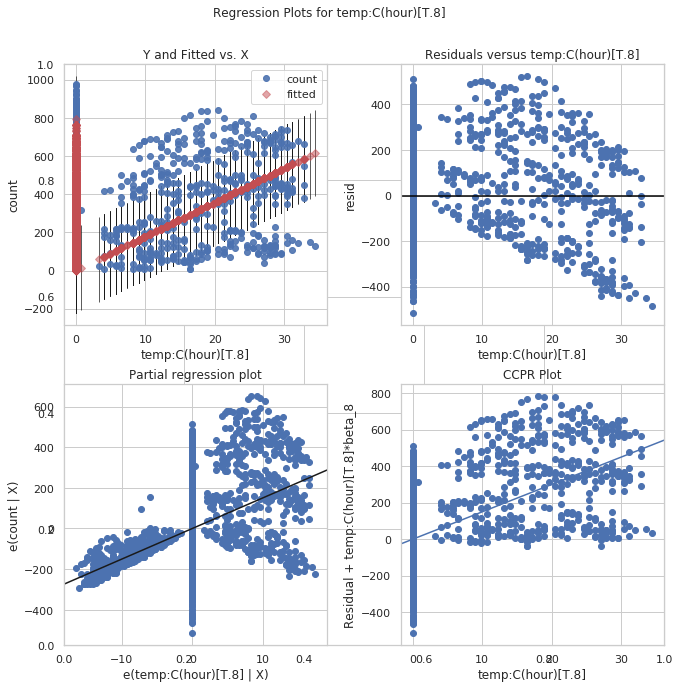

In [197]:
f, ax = plt.subplots(figsize=(10,10))
sm.graphics.plot_regress_exog(rt1, 'temp:C(hour)[T.8]', fig=f)
plt.show()

In [205]:
t2 = 'count ~ temp+C(hour)-1'
m2 = sm.OLS.from_formula(t2, df)
rt2 = m2.fit()
rt2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     662.9
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        22:29:16   Log-Likelihood:                -67135.
No. Observations:               10886   AIC:                         1.343e+05
Df Residuals:                   10861   BIC:                         1.345e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
C(hour)[0]    -71.9198      6.090    -11.809      0.000     -83.858     -59.982
C(hour)[1]    -90.7030      6.071    -14.941      0.000    -102.603     -78.803
C(hour)[2]   -100.4319      6.091    -16.489      0.000    -112.371     -88.493
C(hour)[3]   -111.4297      6.174    -18.049      0.000    -123.531     -99.328
C(hour)[4]   -114.1228      6.097    -18.717      0.000    -126.074    -102.171
C(hour)[5]    -97.9139      6.015    -16.278      0.000    -109.704     -86.123
C(hour)[6]    -40.5620      5.991     -6.771      0.000     -52.305     -28.819
C(hour)[7]     94.2477      6.010     15.682      0.000      82.467     106.029
C(hour)[8]    239.3962      6.054     39.546      0.000     227.530     251.262
C(hour)[9]     92.4096      6.114     15.116      0.000      80.426     104.393
C(hour)[10]    39.3025      6.180      6.359      0.000      27.188      51.417
C(hour)[11]    68.5862      6.248     10.977      0.000      56.339      80.833
C(hour)[12]   109.4804      6.298     17.385      0.000      97.136     121.825
C(hour)[13]   106.1564      6.350     16.718      0.000      93.710     118.603
C(hour)[14]    88.7598      6.385     13.901      0.000      76.244     101.276
C(hour)[15]    98.7138      6.396     15.434      0.000      86.177     111.251
C(hour)[16]   161.8819      6.383     25.362      0.000     149.370     174.394
C(hour)[17]   317.3748      6.347     50.003      0.000     304.933     329.816
C(hour)[18]   283.1223      6.306     44.900      0.000     270.762     295.482
C(hour)[19]   172.5042      6.250     27.599      0.000     160.252     184.756
C(hour)[20]    89.8530      6.206     14.479      0.000      77.689     102.017
C(hour)[21]    38.2631      6.168      6.204      0.000      26.173      50.353
C(hour)[22]     1.4856      6.136      0.242      0.809     -10.543      13.514
C(hour)[23]   -39.7584      6.107     -6.510      0.000     -51.730     -27.787
temp            6.6826      0.147     45.590      0.000       6.395       6.970
==============================================================================
Omnibus:                     1059.027   Durbin-Watson:                   0.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2283.179
Skew:                           0.616   Prob(JB):                         0.00
Kurtosis:                       4.875   Cond. No.                         305.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

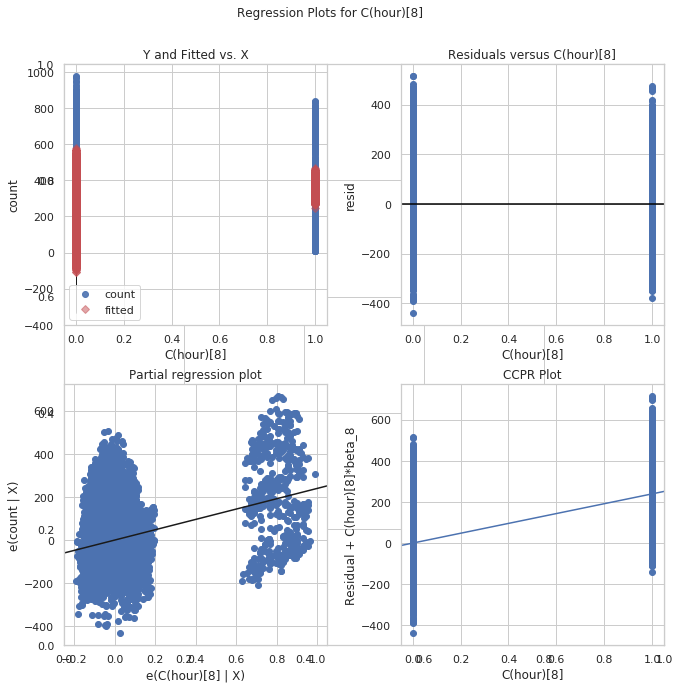

In [208]:
f, ax = plt.subplots(figsize=(10,10))
sm.graphics.plot_regress_exog(rt2, 'C(hour)[8]', fig=f)
plt.show()

#  temp vs hour

- f: 'count ~ temp:C(work_hour)-1'
    - 상수항 없음 
    - 기울기만 변함
    - 부분 회귀: 설명되지 않은 것이 많음
- f: 'count ~ temp:C(work_hour)'
    - 상수항 존재 -> y절편이 0이 아님

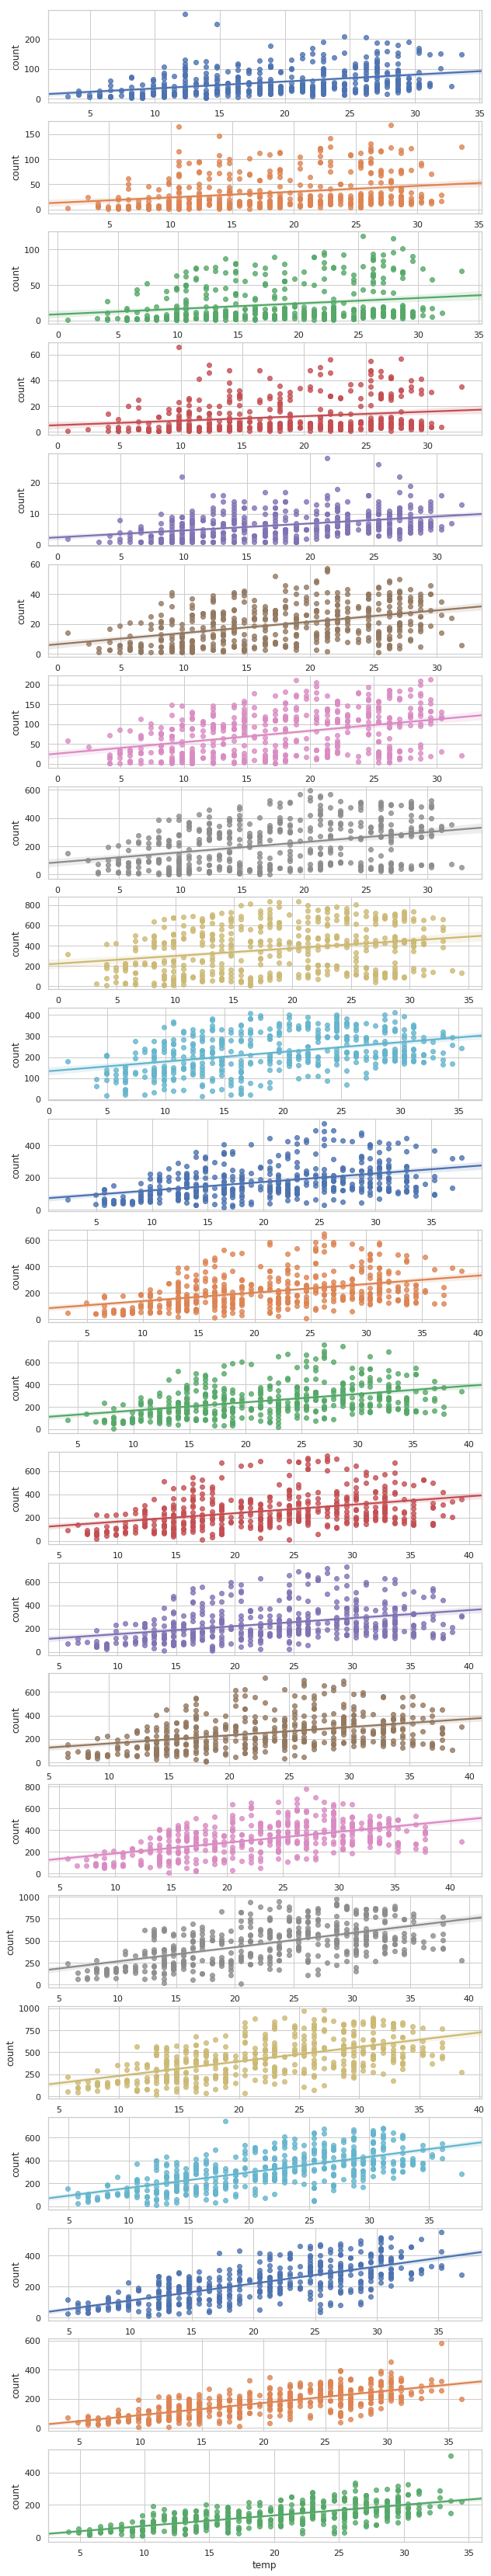

In [159]:
f, axes = plt.subplots(23, 1, figsize=(40,60))
i = 0
for ax in axes:
    cond = df['hour'] == i
    sns.regplot(df[cond]['temp'], df[cond]['count'], ax=ax)
    i += 1
plt.show()


In [228]:
r3 = sm.OLS.from_formula('count ~ temp:C(work_hour)-1 ', df).fit()
r3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     1612.
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        22:51:05   Log-Likelihood:                -64718.
No. Observations:               10886   AIC:                         1.295e+05
Df Residuals:                   10838   BIC:                         1.299e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
temp:C(work_hour)[0_0]      4.9578      0.384     12.895      0.000       4.204       5.711
temp:C(work_hour)[0_1]      3.7468      0.391      9.577      0.000       2.980       4.514
temp:C(work_hour)[0_10]    12.6272      0.355     35.538      0.000      11.931      13.324
temp:C(work_hour)[0_11]    14.9840      0.343     43.708      0.000      14.312      15.656
temp:C(work_hour)[0_12]    16.6439      0.330     50.392      0.000      15.996      17.291
temp:C(work_hour)[0_13]    16.5714      0.322     51.495      0.000      15.941      17.202
temp:C(work_hour)[0_14]    15.9021      0.316     50.268      0.000      15.282      16.522
temp:C(work_hour)[0_15]    15.6814      0.317     49.541      0.000      15.061      16.302
temp:C(work_hour)[0_16]    15.7044      0.320     49.115      0.000      15.078      16.331
temp:C(work_hour)[0_17]    14.9862      0.325     46.111      0.000      14.349      15.623
temp:C(work_hour)[0_18]    13.4107      0.332     40.335      0.000      12.759      14.062
temp:C(work_hour)[0_19]    11.6421      0.344     33.868      0.000      10.968      12.316
temp:C(work_hour)[0_2]      2.8406      0.398      7.142      0.000       2.061       3.620
temp:C(work_hour)[0_20]     9.1610      0.353     25.957      0.000       8.469       9.853
temp:C(work_hour)[0_21]     7.6136      0.362     21.043      0.000       6.904       8.323
temp:C(work_hour)[0_22]     6.3478      0.368     17.272      0.000       5.627       7.068
temp:C(work_hour)[0_23]     4.7024      0.376     12.523      0.000       3.966       5.438
temp:C(work_hour)[0_3]      1.3717      0.402      3.411      0.001       0.583       2.160
temp:C(work_hour)[0_4]      0.4638      0.408      1.137      0.255      -0.336       1.263
temp:C(work_hour)[0_5]      0.5298      0.415      1.275      0.202      -0.285       1.344
temp:C(work_hour)[0_6]      1.1317      0.416      2.722      0.006       0.317       1.947
temp:C(work_hour)[0_7]      2.5642      0.408      6.285      0.000       1.764       3.364
temp:C(work_hour)[0_8]      5.8345      0.391     14.926      0.000       5.068       6.601
temp:C(work_hour)[0_9]      8.9987      0.373     24.102      0.000       8.267       9.731
temp:C(work_hour)[1_0]      1.8730      0.257      7.292      0.000       1.370       2.377
temp:C(work_hour)[1_1]      0.8277      0.262      3.164      0.002       0.315       1.340
temp:C(work_hour)[1_10]     6.1296      0.240     25.545      0.000       5.659       6.600
temp:C(work_hour)[1_11]     6.9953      0.230     30.357      0.000       6.544       7.447
temp:C(work_hour)[1_12]     8.6422      0.224     38.638      0.000       8.204       9.081
temp:C(work_hour)[1_13]     8.3131      0.218     38.166      0.000       7.886       8.740
temp:C(work_hour)[1_14]     7.4872      0.214  

In [ ]:
r3

# temp*work_hour

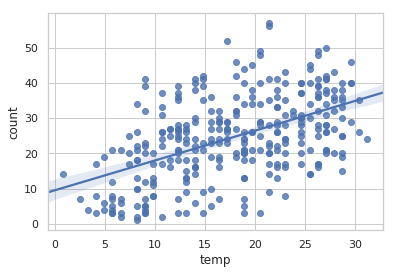

In [232]:
cond = df['work_hour'] == df['work_hour'].unique()[27]
sns.regplot(df[cond]['temp'], df[cond]['count'])
plt.show()

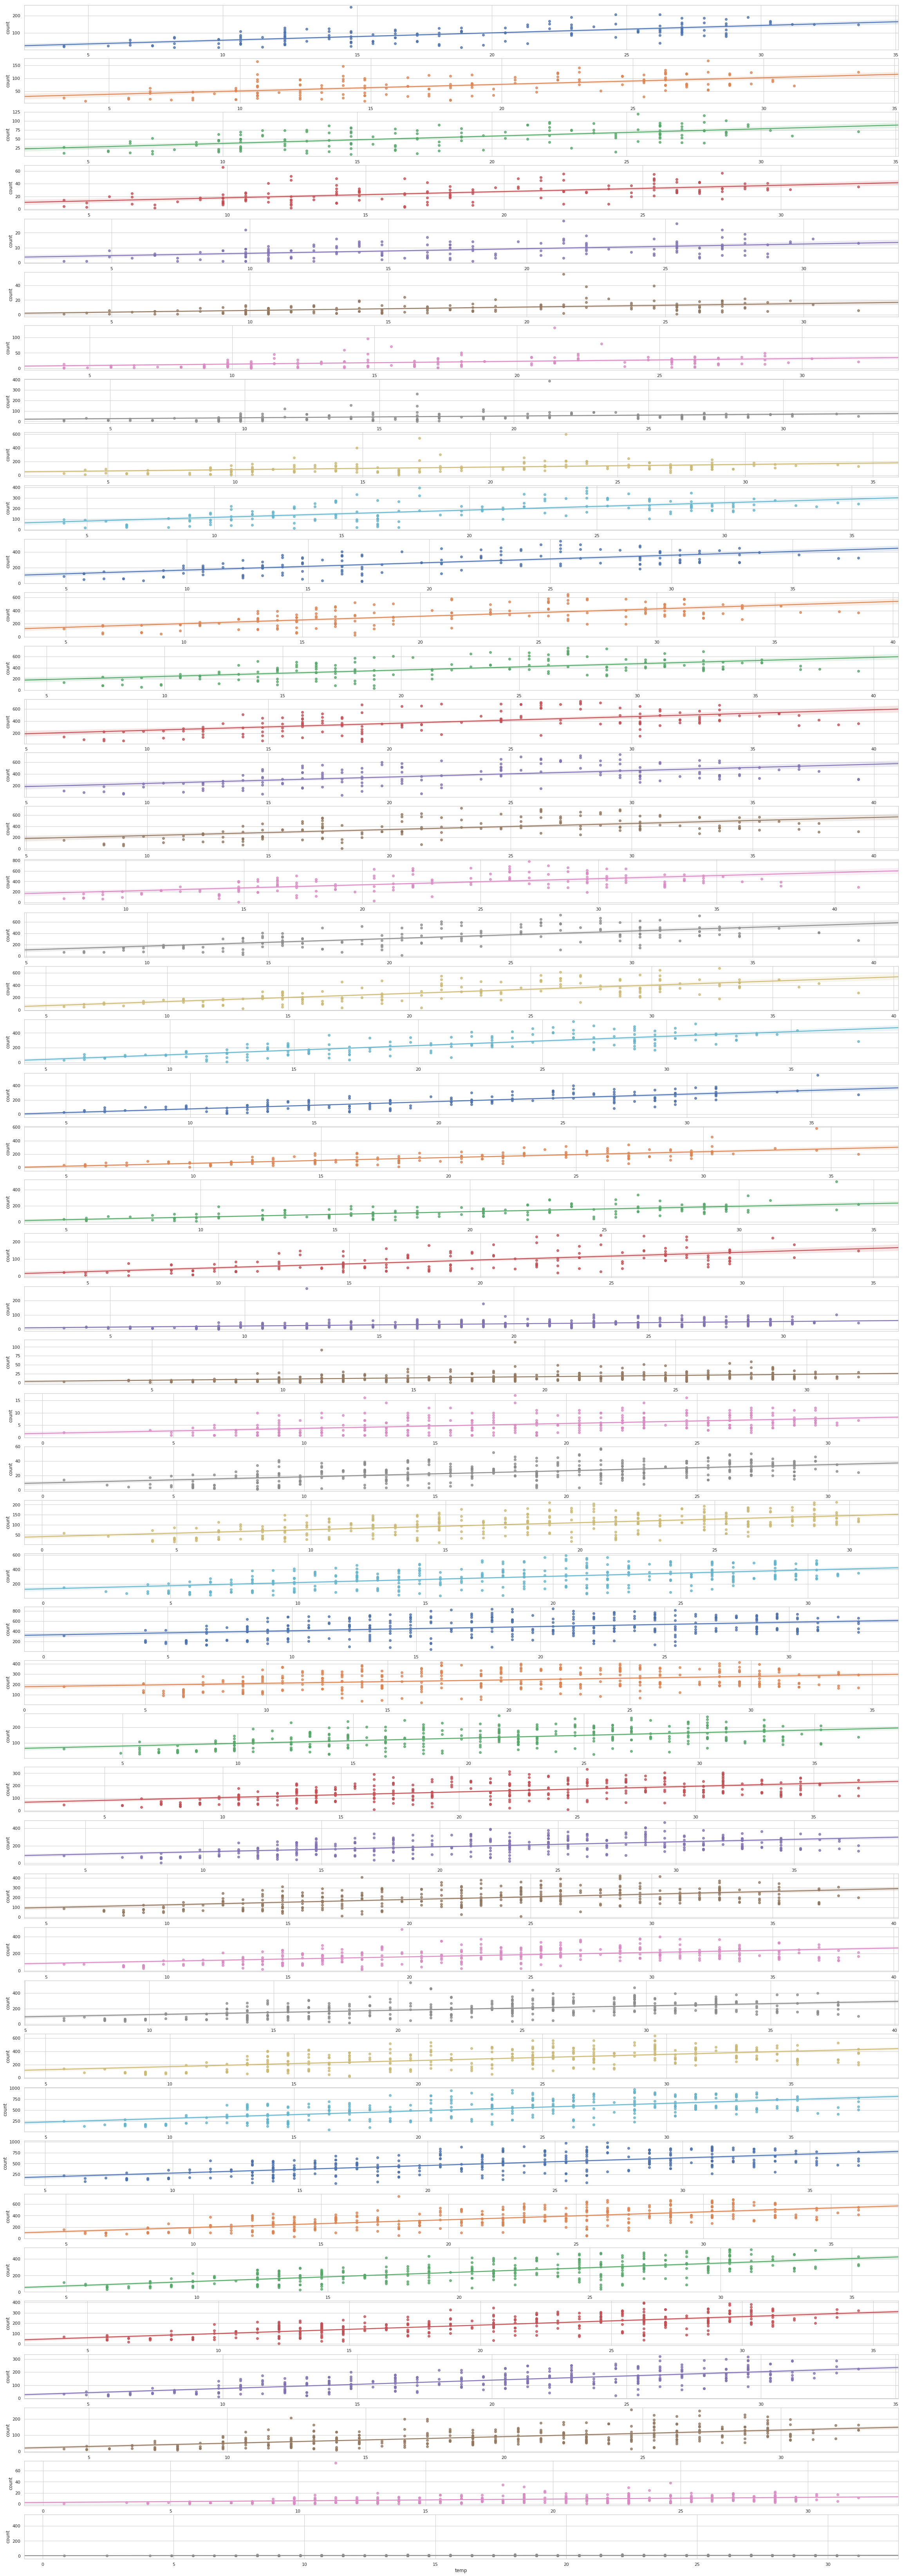

In [253]:
f, axes = plt.subplots(48, 1, figsize=(40,120))
i = 0
for ax in axes:
    cond = df['work_hour'] == df['work_hour'].unique()[i]
    sns.regplot(df[cond]['temp'], df[cond]['count'], ax=ax)
    i += 1
plt.show()

In [4]:
?make_regression

Object `make_regression` not found.


In [9]:
import statsmodels.api as sm
from sklearn.datasets import make_regression
X0, y, coef = make_regression(
    n_samples=100, n_features=1, noise=30, bias=100, coef=True, random_state=0)
dfX = pd.DataFrame(X0, columns=["X"])
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model1 = sm.OLS.from_formula("Y ~ X", data=df)
result1 = model1.fit()
model2 = sm.OLS.from_formula("Y ~ X + 0", data=df)
result2 = model2.fit()

In [14]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     22.87
Date:                Sat, 15 Dec 2018   Prob (F-statistic):           6.03e-06
Time:                        23:44:15   Log-Likelihood:                -604.91
No. Observations:                 100   AIC:                             1212.
Df Residuals:                      99   BIC:                             1214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             48.8109     10.206      4.783      0.000      28.561      69.061
==============================================================================
Omnibus:                        3.876   Durbin-Watson:                   0.204
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                2.209
Skew:                          -0.092   Prob(JB):                        0.331
Kurtosis:                       2.296   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     179.9
Date:                Sat, 15 Dec 2018   Prob (F-statistic):           6.60e-24
Time:                        23:44:23   Log-Likelihood:                -488.64
No. Observations:                 100   AIC:                             981.3
Df Residuals:                      98   BIC:                             986.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     97.5575      3.244     30.075      0.000      91.120     103.995
X             43.0873      3.213     13.411      0.000      36.712      49.463
==============================================================================
Omnibus:                        3.523   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                2.059
Skew:                          -0.073   Prob(JB):                        0.357
Kurtosis:                       2.312   Cond. No.                         1.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

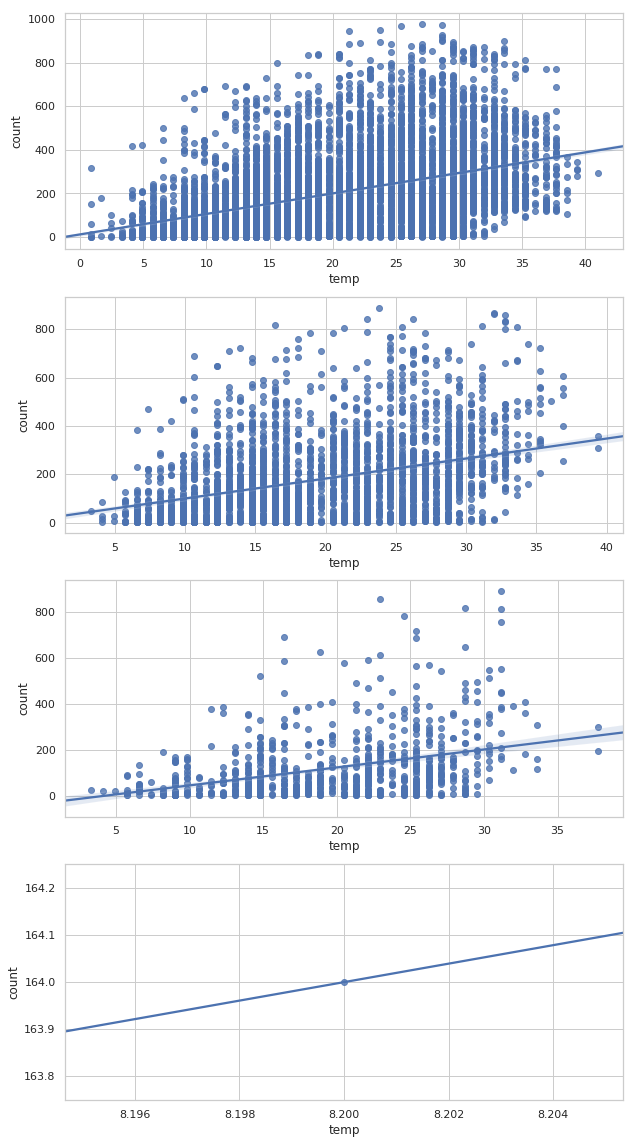

In [113]:
plt.figure(figsize=(10,20))

plt.subplot(411)
cond = df['weather'] == 1
sns.regplot(df[cond]['temp'], df[cond]['count'])

plt.subplot(412)
cond = df['weather'] == 2
sns.regplot(df[cond]['temp'], df[cond]['count'])

plt.subplot(413)
cond = df['weather'] == 3
sns.regplot(df[cond]['temp'], df[cond]['count'])

plt.subplot(414)
cond = df['weather'] == 4
sns.regplot(df[cond]['temp'], df[cond]['count'])

plt.show()

In [22]:
from sklearn.model_selection import KFold

def stats_kfold(model, data=df, formula=f, y_col_name='count'):
   
        scores = np.zeros(5)
        cv = KFold(5, shuffle=True, random_state=0)
        
        for i, (idx_train, idx_test) in enumerate(cv.split(data)):
            df_train = data.iloc[idx_train]
            df_test = data.iloc[idx_test]
            
            # 모델 변경 필요
            # model = sm.OLS.from_formula(f, data=df_train)
            # result = model.fit_regularized(alpha=10, L1_wt=0)
            
            pred = model.predict(df_test)
            rss = ((df_test[y_col_name] - pred)**2).sum()
            tss = ((df_test[y_col_name] - df_test[y_col_name].mean())**2).sum()
            rsquared = 1 - rss / tss
            
            scores[i] = rsquared
            # print("test R2 = {:.8f}".format(rsquared))
            print("train R2 = {:.8f}, test R2 = {:.8f}".format(model.rsquared, rsquared))

In [42]:
glm

'np.log(casual+1) ~ humidity/C(hour_dow) + temp/C(work_hour) + windspeed/C(work_hour) -1'

In [49]:
f1 = 'casual ~ humidity/C(hour_dow) + temp/C(work_hour) + windspeed/C(work_hour) -1'
glm1 = sm.GLM.from_formula(f1, df, family=sm.families.Poisson())
glm_res1 = glm1.fit()

In [50]:
f2 = "registered ~ humidity/C(work_hour) + temp/C(work_hour) + windspeed/C(work_hour)-1"
glm2 = sm.GLM.from_formula(f2, df, family=sm.families.Poisson())
glm_res2 = glm2.fit()

In [62]:
a = glm_res2.predict(df)
b = glm_res1.predict(df)

sub = pd.read_csv("sampleSubmission.csv")
sub['count'] = a + b
sub.fillna(0, inplace=True)
sub.loc[sub['count'] < 0, 'count'] = 0
sub.to_csv("submission1.csv", index=False)



In [5]:
glm_res = glm.fit()

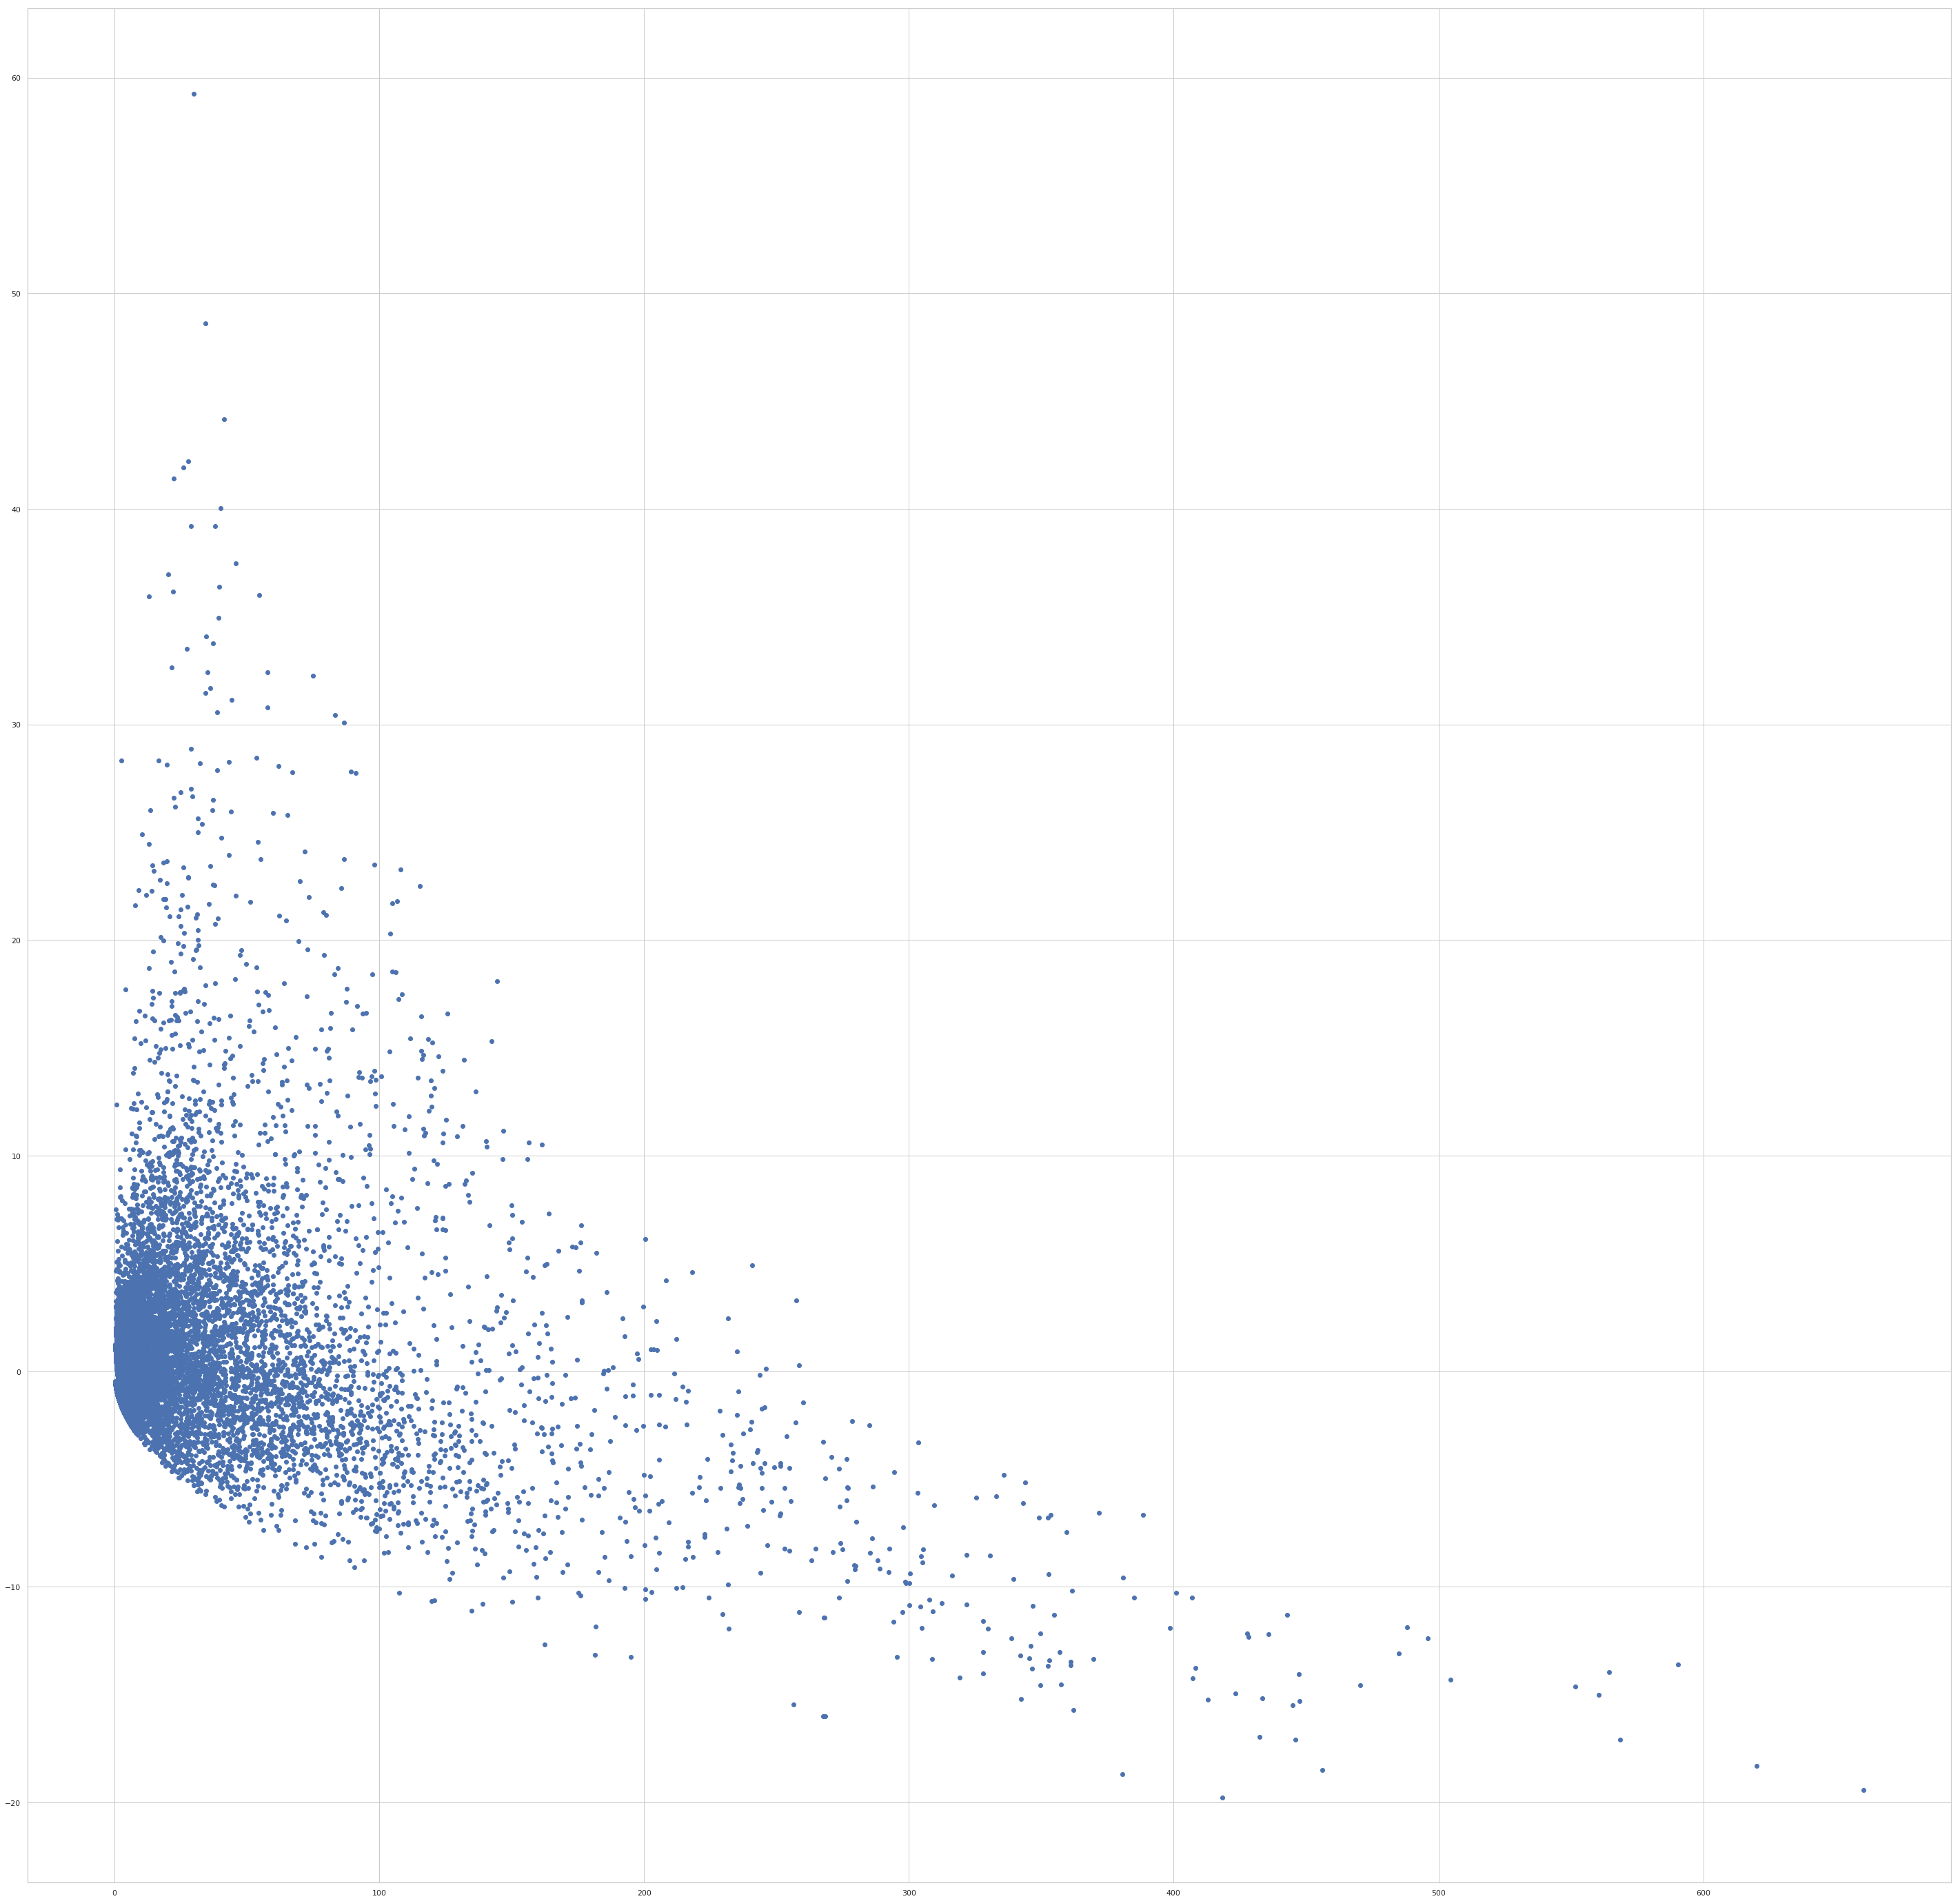

In [59]:
plt.figure(figsize=(50,50))
plt.scatter(glm_res.fittedvalues, glm_res.resid_pearson)
plt.show()

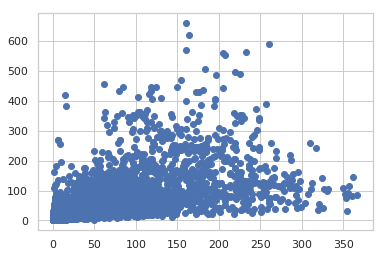

In [20]:
plt.scatter(glm.endog, glm_res.fittedvalues)

In [17]:
glm_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
===============================================================================
Model:                   GLM                   AIC:                 250270.2263
Link Function:           log                   BIC:                 104301.7551
Dependent Variable:      casual                Log-Likelihood:      -1.2487e+05
Date:                    2018-12-12 22:11      LL-Null:             -3.0539e+05
No. Observations:        10886                 Deviance:            2.0304e+05 
Df Model:                263                   Pearson chi2:        2.76e+05   
Df Residuals:            10622                 Scale:               1.0000     
Method:                  IRLS                                                  
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------
humidity                        0.0058   0.0008   7.0093 0.0000  0.0042  0.0075
humidity:C(hour_dow)[T.0_1]    -0.0078   0.0009  -8.3354 0.0000 -0.0096 -0.0059
humidity:C(hour_dow)[T.0_2]    -0.0081   0.0009  -8.9814 0.0000 -0.0099 -0.0064
humidity:C(hour_dow)[T.0_3]    -0.0059   0.0009  -6.5246 0.0000 -0.0076 -0.0041
humidity:C(hour_dow)[T.0_4]     0.0003   0.0008   0.3124 0.7547 -0.0014  0.0019
humidity:C(hour_dow)[T.0_5]     0.0017   0.0009   1.8192 0.0689 -0.0001  0.0034
humidity:C(hour_dow)[T.0_6]     0.0017   0.0009   1.8414 0.0656 -0.0001  0.0035
humidity:C(hour_dow)[T.10_0]    0.0109   0.0009  11.6655 0.0000  0.0091  0.0128
humidity:C(hour_dow)[T.10_1]    0.0045   0.0010   4.6155 0.0000  0.0026  0.0065
humidity:C(hour_dow)[T.10_2]    0.0047   0.0010   4.8140 0.0000  0.0028  0.0066
humidity:C(hour_dow)[T.10_3]    0.0049   0.0010   4.9480 0.0000  0.0030  0.0069
humidity:C(hour_dow)[T.10_4]    0.0101   0.0010  10.5263 0.0000  0.0083  0.0120
humidity:C(hour_dow)[T.10_5]    0.0150   0.0009  16.0866 0.0000  0.0132  0.0168
humidity:C(hour_dow)[T.10_6]    0.0169   0.0009  18.2715 0.0000  0.0150  0.0187
humidity:C(hour_dow)[T.11_0]    0.0103   0.0009  11.0934 0.0000  0.0085  0.0121
humidity:C(hour_dow)[T.11_1]    0.0020   0.0010   2.0493 0.0404  0.0001  0.0039
humidity:C(hour_dow)[T.11_2]    0.0036   0.0010   3.7274 0.0002  0.0017  0.0055
humidity:C(hour_dow)[T.11_3]    0.0054   0.0010   5.4923 0.0000  0.0035  0.0073
humidity:C(hour_dow)[T.11_4]    0.0105   0.0010  11.0411 0.0000  0.0086  0.0124
humidity:C(hour_dow)[T.11_5]    0.0171   0.0009  18.7810 0.0000  0.0153  0.0189
humidity:C(hour_dow)[T.11_6]    0.0175   0.0009  19.3243 0.0000  0.0157  0.0193
humidity:C(hour_dow)[T.12_0]    0.0105   0.0009  11.3832 0.0000  0.0087  0.0124
humidity:C(hour_dow)[T.12_1]    0.0023   0.0010   2.3439 0.0191  0.0004  0.0042
humidity:C(hour_dow)[T.12_2]    0.0035   0.0010   3.6457 0.0003  0.0016  0.0054
humidity:C(hour_dow)[T.12_3]    0.0042   0.0010   4.2216 0.0000  0.0022  0.0061
humidity:C(hour_dow)[T.12_4]    0.0112   0.0009  11.8049 0.0000  0.0093  0.0131
humidity:C(hour_dow)[T.12_5]    0.0201   0.0009  22.6042 0.0000  0.0184  0.0219
humidity:C(hour_dow)[T.12_6]    0.0201   0.0009  22.5679 0.0000  0.0184  0.0219
humidity:C(hour_dow)[T.13_0]    0.0093   0.0009   9.9740 0.0000  0.0075  0.0112
humidity:C(hour_dow)[T.13_1]    0.0013   0.0010   1.3148 0.1886 -0.0006  0.0032
humidity:C(hour_dow)[T.13_2]    0.0028   0.0010   2.8165 0.0049  0.0008  0.0047
humidity:C(hour_dow)[T.13_3]    0.0046   0.0010   4.5917 0.0000  0.0026  0.0065
humidity:C(hour_dow)[T.13_4]    0.0115   0.0010  11.9816 0.0000  0.0096  0.0133
humidity:C(hour_dow)[T.13_5]    0.0186   0.0009  20.6798 0.0000  0.0168  0.0203
humidity:C(hour_dow)[T.13_6]    0.0180   0.0009  20.1267 0.0000  0.0163  0.0198
humidity:C(hour_dow)[T.14_0]    0.0093   0.0009   9.9705 0.0000  0.0074  0.0111
humidity:C(hour_dow)[T.14_1]    0.0007   0.0010   0.68

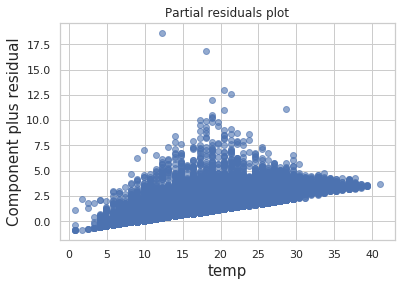

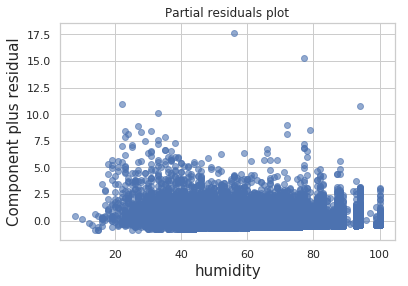

In [51]:
glm_res.plot_partial_residuals('temp')
glm_res.plot_partial_residuals('humidity')
plt.show()

In [46]:
sm.graphics.plot_regress_exog(glm_res, 'temp')

AttributeError: 'GLMResults' object has no attribute 'mse_resid'

<Figure size 432x288 with 0 Axes>

In [64]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dayofweek', 'date', 'weekend',
       'hour_dow', 'work_hour'],
      dtype='object')

In [ ]:
f = 'count ~ '

# 정규화

In [6]:
from patsy import *
import statsmodels.api as sm
cridge_mod = modc.fit_regularized(alpha=0.1, L1_wt=0)
classo_mod = modc.fit_regularized(alpha=0.1, L1_wt=1)

rridge_mod = modr.fit_regularized(alpha=10.1, L1_wt=0)
rlasso_mod = modr.fit_regularized(alpha=0.1, L1_wt=1)

# 최적정규화

In [38]:
f = "humidity/C(hour_dow) + temp/C(work_hour) + windspeed/C(work_hour) -1"
dfx = sm.add_constant(dmatrix(f, df))
y = df['casual']

In [39]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# boston = load_boston()
# X = boston.data
# y = boston.target

alphas = np.logspace(-4, 0, 200)

train_scores = []
test_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(dfx, y).predict(dfx))
    test_score = np.mean(cross_val_score(model, dfx, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
blt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [40]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
    Lasso(), dfx, y, "alpha", alphas, cv=5,
    scoring="neg_mean_squared_error")

plt.plot(alphas, test_scores.mean(axis=1), "-", label="검증성능 평균")
plt.plot(alphas, train_scores.mean(axis=1), "--", label="학습성능 평균")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.title("최적 정규화")
plt.show()

KeyboardInterrupt: 

In [123]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dayofweek', 'date', 'weekend',
       'hour_dow', 'work_hour'],
      dtype='object')

In [251]:
import itertools
ls = ['workingday', 'hour', 'year', 'month', 'weekend']
comb = tuple(itertools.combinations(ls, 2))

for elem in comb:
    s = "C({}):C({}):humidity".format(elem[0], elem[1])
    ls.append(s)

def cat_rsquare(y, cat_list, df):
    result_dict = {}
    for cat in cat_list:
        f = '{} ~ {} -1'.format(y, cat)
        r = sm.OLS.from_formula(f, data=df).fit().rsquared_adj
        result_dict[cat] = float("{:.3f}".format(r))
    return pd.DataFrame([result_dict]).T.sort_values(0, ascending=False).rename(columns={0:'{}(r square)'.format(y)})[:5]

In [250]:
# humidity 
cat_rsquare('casual', ls, df)

casual(r square)
C(workingday):C(hour)/humidity              0.560
C(hour):C(weekend)/humidity                 0.555
C(hour):C(month)/humidity                   0.524
C(workingday):C(month)/humidity             0.510
C(month):C(weekend)/humidity                0.498

In [135]:
cat_rsquare('registered', ls, df)

registered(r square)
C(workingday):C(hour)/windspeed                 0.695
C(hour):C(weekend)/windspeed                    0.686
C(hour):C(year)/windspeed                       0.639
C(hour):C(month)/windspeed                      0.606
hour                                            0.528

In [137]:
# temp
cat_rsquare('registered', ls, df)

registered(r square)
C(workingday):C(hour)*temp                 0.766
C(hour):C(weekend)*temp                    0.757
C(hour):C(year)*temp                       0.699
C(hour):C(month)*temp                      0.631
hour                                       0.528

In [139]:
cat_rsquare('registered', ls, df)

registered(r square)
C(workingday):C(hour)/temp                 0.766
C(hour):C(weekend)/temp                    0.757
C(hour):C(year)/temp                       0.699
C(hour):C(month)/temp                      0.631
hour                                       0.528

In [36]:
cat_rsquare('registered', ls, df)

registered(r square)
C(workingday):C(hour)/windspeed                 0.695
C(hour):C(dayofweek)/windspeed                  0.690
C(hour):C(weekend)/windspeed                    0.686
C(year):C(hour)/windspeed                       0.639
C(month):C(hour)/windspeed                      0.606

In [117]:
# registered: windspeed
cat_rsquare('registered', ls, df)

registered(r square)
C(workingday):C(hour)*windspeed                 0.695
C(hour):C(dayofweek)*windspeed                  0.690
C(hour):C(weekend)*windspeed                    0.686
C(year):C(hour)*windspeed                       0.639
C(month):C(hour)*windspeed                      0.606

In [118]:
# casual: windspeed
cat_rsquare('casual', ls, df)

casual(r square)
C(workingday):C(hour)*windspeed             0.540
C(hour):C(dayofweek)*windspeed              0.537
C(hour):C(weekend)*windspeed                0.531
C(month):C(hour)*windspeed                  0.478
C(season):C(hour)*windspeed                 0.447

In [19]:
fc = "np.log(casual+1) ~ humidity/C(hour_dow) + temp/C(work_hour) + windspeed/C(work_hour) -1"

In [21]:
df['log_count'] = np.log1p(df['count'])

In [26]:
def stats_kfold(data=df, formula=fc, y_col_name='count'):
    from sklearn.model_selection import KFold

    scores = np.zeros(5)
    cv = KFold(5, shuffle=True, random_state=0)
    
    for i, (idx_train, idx_test) in enumerate(cv.split(df)):
        df_train = df.iloc[idx_train]
        df_test = df.iloc[idx_test]
        
        # 모델 변경 필요
        model = sm.OLS.from_formula(fc, data=df_train)
        # ridge
        # result = model.fit_regularized(alpha=10, L1_wt=0)
        result = model.fit()
        
        pred = result.predict(df_test)
        rss = ((df_test[y_col_name] - (np.exp(pred)-1)**2).sum()
        tss = ((df_test[y_col_name] - df_test[y_col_name].mean())**2).sum()
        rsquared = 1 - rss / tss
        
        scores[i] = rsquared
        # print("test R2 = {:.8f}".format(rsquared))
        print("train R2 = {:.8f}, test R2 = {:.8f}".format(result.rsquared, rsquared))

In [27]:
stats_kfold()

train R2 = 0.94894501, test R2 = -1.09617820
train R2 = 0.94941411, test R2 = -1.12784067
train R2 = 0.95032742, test R2 = -1.04910939
train R2 = 0.95001829, test R2 = -1.03352424
train R2 = 0.94899679, test R2 = -1.08433348


In [ ]:
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df)):
  df_train = df.iloc[idx_train]
  df_test = df.iloc[idx_test]

  model = sm.OLS.from_formula(X, data=df_train)
  result = model.fit()

  pred = result.predict(df_test)
  rss = ((df_test['count_log'] - pred) ** 2).sum()
  tss = ((df_test['count_log'] - df_test['count_log'].mean())** 2).sum()
  rsquared = 1 - rss / tss

  scores[i] = rsquared
  print("train R2 = {:.8f}, test R2 = {:.8f}".format(result.rsquared, rsquared))